# Huntington Candidates Analysis

This notebook evaluates drug candidates for Huntington's Disease by scoring them against:
1. Huntington Protein (HTT)
2. Huntington Disease

We analyze the ranking of candidates based on their PROTON scores and overlay their PubChem activity outcomes.

In [1]:
import logging
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Setup logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
_logger = logging.getLogger(__name__)

# --- Path Setup ---
def _find_repo_root(start: Path) -> Path:
    start = start.resolve()
    for parent in (start, *start.parents):
        if (parent / "pyproject.toml").exists():
            return parent
    return start

PROJECT_ROOT = _find_repo_root(Path.cwd())
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
    
# Change working directory to root for correct config loading
os.chdir(PROJECT_ROOT)

from src.config import conf
from src.constants import TORCH_DEVICE
from src.dataloaders import load_graph
from src.models import HGT

_logger.info(f"Working from: {os.getcwd()}")
_logger.info(f"Device: {TORCH_DEVICE}")

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "sans-serif"

[02/04/26 16:44:32] INFO     Working from: /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM      ]8;id=649889;file:///tmp/ipykernel_2074843/138076137.py\138076137.py]8;;\:]8;id=144134;file:///tmp/ipykernel_2074843/138076137.py#37\37]8;;\

                    INFO     Device: cuda                                                           ]8;id=420979;file:///tmp/ipykernel_2074843/138076137.py\138076137.py]8;;\:]8;id=992342;file:///tmp/ipykernel_2074843/138076137.py#38\38]8;;\

In [2]:
# 1. Load Nodes and Edges
_logger.info("Loading graph structure...")
nodes = pd.read_csv(conf.paths.kg.nodes_path, dtype={"node_index": int}, low_memory=False)
edges = pd.read_csv(
    conf.paths.kg.edges_path, 
    dtype={"edge_index": int, "x_index": int, "y_index": int}, 
    low_memory=False
)
kg = load_graph(nodes, edges)

# 2. Load Pretrained Model
_logger.info("Loading PROTON model...")
pretrain_model = HGT.load_from_checkpoint(
    checkpoint_path=str(conf.paths.checkpoint.checkpoint_path),
    kg=kg,
    strict=False,
)
pretrain_model.eval()
pretrain_model = pretrain_model.to(TORCH_DEVICE)

# 3. Load Pretrained Embeddings
_logger.info("Loading pretrained embeddings...")
pretrained_embeddings = torch.load(conf.paths.checkpoint.embeddings_path, map_location='cpu')
_logger.info(f"Pretrained embeddings shape: {pretrained_embeddings.shape}")

[02/04/26 16:44:33] INFO     Loading graph structure...                                             ]8;id=946998;file:///tmp/ipykernel_2074843/1418713357.py\1418713357.py]8;;\:]8;id=30213;file:///tmp/ipykernel_2074843/1418713357.py#2\2]8;;\

[02/04/26 16:45:09] INFO     Loading PROTON model...                                               ]8;id=693065;file:///tmp/ipykernel_2074843/1418713357.py\1418713357.py]8;;\:]8;id=251512;file:///tmp/ipykernel_2074843/1418713357.py#12\12]8;;\

[02/04/26 16:45:41] INFO     Loading pretrained embeddings...                                      ]8;id=867496;file:///tmp/ipykernel_2074843/1418713357.py\1418713357.py]8;;\:]8;id=480678;file:///tmp/ipykernel_2074843/1418713357.py#22\22]8;;\

[02/04/26 16:45:42] INFO     Pretrained embeddings shape: torch.Size([147020, 512])                ]8;id=951674;file:///tmp/ipykernel_2074843/1418713357.py\1418713357.py]8;;\:]8;id=520242;file:///tmp/ipykernel_2074843/1418713357.py#24\24]8;;\

In [35]:
# Identify Targets
# 1. Huntington Protein (HTT)
protein_nodes = nodes[nodes['node_type'] == 'gene/protein']
htt_target = protein_nodes[nodes['node_name'] == 'HTT']

if len(htt_target) == 0:
    _logger.warning("Exact match for 'HTT' not found. Searching contains...")
    htt_target = protein_nodes[nodes['node_name'].str.contains('HTT', case=False)]

if len(htt_target) > 0:
    htt_idx = htt_target.iloc[0]['node_index']
    htt_name = htt_target.iloc[0]['node_name']
    _logger.info(f"Found Protein Target: {htt_name} (Index: {htt_idx})")
else:
    raise ValueError("Could not find HTT protein in graph.")

# 2. Huntington Disease
disease_nodes = nodes[nodes['node_type'] == 'disease']
hd_target = disease_nodes[disease_nodes['node_name'].str.contains("Huntington", case=False)]

print("Found disease nodes matching 'Huntington':")
display(hd_target[['node_name', 'node_index']].head())

if len(hd_target) > 0:
    # Pick the most specific one, usually "Huntington disease"
    exact_match = hd_target[hd_target['node_name'].str.lower() == "huntington disease"]
    if len(exact_match) > 0:
        hd_idx = exact_match.iloc[0]['node_index']
        hd_name = exact_match.iloc[0]['node_name']
    else:
         hd_idx = hd_target.iloc[0]['node_index']
         hd_name = hd_target.iloc[0]['node_name']
    
    _logger.info(f"Selected Disease Target: {hd_name} (Index: {hd_idx})")
else:
    raise ValueError("Could not find Huntington disease in graph.")

[02/04/26 17:45:06] WARNING  /tmp/ipykernel_2074843/577901598.py:4: UserWarning: Boolean Series key ]8;id=535383;file:///usr/lib64/python3.11/warnings.py\warnings.py]8;;\:]8;id=723869;file:///usr/lib64/python3.11/warnings.py#110\110]8;;\
                             will be reindexed to match DataFrame index.                                           
                               htt_target = protein_nodes[nodes['node_name'] == 'HTT']                             
                                                                                                                   

                    INFO     Found Protein Target: HTT (Index: 2754)                                ]8;id=29515;file:///tmp/ipykernel_2074843/577901598.py\577901598.py]8;;\:]8;id=948362;file:///tmp/ipykernel_2074843/577901598.py#13\13]8;;\

Found disease nodes matching 'Huntington':


,node_name,node_index
29909,Huntington disease,29909
30040,Huntington disease-like 2,30040
30409,Huntington disease-like 1,30409
32625,Huntington disease-like 3,32625
35976,Huntington disease-like syndrome due to C9ORF7...,35976


                    INFO     Selected Disease Target: Huntington disease (Index: 29909)             ]8;id=853500;file:///tmp/ipykernel_2074843/577901598.py\577901598.py]8;;\:]8;id=970948;file:///tmp/ipykernel_2074843/577901598.py#34\34]8;;\

In [36]:
# Load Candidate Embeddings and Metadata
candidates_emb_path = PROJECT_ROOT / "notebooks/molecular_analysis/huntington_candidates_embeddings.pt"
candidates_csv_path = PROJECT_ROOT / "notebooks/molecular_analysis/huntington_candidates_filtered_molecules_with_embeddings.csv"

_logger.info(f"Loading candidate embeddings from {candidates_emb_path}")
res_embeddings = torch.load(candidates_emb_path, map_location='cpu')

_logger.info(f"Loading candidate metadata from {candidates_csv_path}")
candidates_df = pd.read_csv(candidates_csv_path)

_logger.info(f"Embeddings shape: {res_embeddings.shape}")
_logger.info(f"Metadata shape: {candidates_df.shape}")

# Ensure alignment
if len(res_embeddings) != len(candidates_df):
    _logger.warning(f"Length mismatch! Embeddings: {len(res_embeddings)}, Metadata: {len(candidates_df)}")
    # Assuming they are aligned and taking common length
    min_len = min(len(res_embeddings), len(candidates_df))
    res_embeddings = res_embeddings[:min_len]
    candidates_df = candidates_df.iloc[:min_len]
    _logger.info(f"Trimmed to {min_len} candidates.")

# --- Filter for Actives Only (Exclude Inactive/Inconclusive) ---
if 'pubchem_activity_outcome' in candidates_df.columns:
    _logger.info("Filtering for ACTIVE compounds only...")
    outcomes = candidates_df['pubchem_activity_outcome'].astype(str).str.strip().str.lower()
    
    # Keep only actives
    active_mask = (outcomes == 'active')
    active_indices = np.where(active_mask)[0]
    
    candidates_df = candidates_df.iloc[active_indices].reset_index(drop=True)
    res_embeddings = res_embeddings[active_indices]
    
    _logger.info(f"Filtered to {len(candidates_df)} ACTIVE candidates.")
else:
    _logger.warning("Column 'pubchem_activity_outcome' not found. Skipping filtering.")

# Combine Embeddings for Model Lookup
# We append candidate embeddings to the pretrained ones
combined_embeddings = torch.cat([pretrained_embeddings, res_embeddings], dim=0)
num_pretrained = len(pretrained_embeddings)
candidate_indices = torch.arange(num_pretrained, num_pretrained + len(res_embeddings), dtype=torch.long)

_logger.info(f"Combined embeddings shape: {combined_embeddings.shape}")

                    INFO     Loading candidate embeddings from                                       ]8;id=968274;file:///tmp/ipykernel_2074843/555441538.py\555441538.py]8;;\:]8;id=541774;file:///tmp/ipykernel_2074843/555441538.py#5\5]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/notebooks/molecular               
                             _analysis/huntington_candidates_embeddings.pt                                         

                    INFO     Loading candidate metadata from                                         ]8;id=596407;file:///tmp/ipykernel_2074843/555441538.py\555441538.py]8;;\:]8;id=385398;file:///tmp/ipykernel_2074843/555441538.py#8\8]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/notebooks/molecular               
                             _analysis/huntington_candidates_filtered_molecules_with_embeddings.csv                

                    INFO     Embeddings shape: torch.Size([906, 512])                               ]8;id=835282;file:///tmp/ipykernel_2074843/555441538.py\555441538.py]8;;\:]8;id=618467;file:///tmp/ipykernel_2074843/555441538.py#11\11]8;;\

                    INFO     Metadata shape: (906, 41)                                              ]8;id=618902;file:///tmp/ipykernel_2074843/555441538.py\555441538.py]8;;\:]8;id=543136;file:///tmp/ipykernel_2074843/555441538.py#12\12]8;;\

                    INFO     Filtering for ACTIVE compounds only...                                 ]8;id=490168;file:///tmp/ipykernel_2074843/555441538.py\555441538.py]8;;\:]8;id=323765;file:///tmp/ipykernel_2074843/555441538.py#25\25]8;;\

                    INFO     Filtered to 55 ACTIVE candidates.                                      ]8;id=597307;file:///tmp/ipykernel_2074843/555441538.py\555441538.py]8;;\:]8;id=425075;file:///tmp/ipykernel_2074843/555441538.py#35\35]8;;\

                    INFO     Combined embeddings shape: torch.Size([147075, 512])                   ]8;id=84742;file:///tmp/ipykernel_2074843/555441538.py\555441538.py]8;;\:]8;id=7844;file:///tmp/ipykernel_2074843/555441538.py#45\45]8;;\

In [37]:
# Compute Scores

# Function to compute scores
def compute_scores(target_idx, target_type, relation_type):
    # We want Score(Candidate -> Target)
    # Edge: (Drug, relation, TargetType)
    
    canonical_etypes = kg.canonical_etypes
    etype = None
    
    # Try forward: Drug -> Target
    for et in canonical_etypes:
        # Check source is drug and target fits
        if et[0] == 'drug' and et[2] == target_type and relation_type in et[1]:
            etype = et
            break
            
    if etype is None:
        _logger.error(f"Could not find edge type for Drug -> {target_type} with relation {relation_type}")
        return None

    _logger.info(f"Scoring using edge: {etype}")
    
    batch_src = candidate_indices # Drugs
    batch_dst = torch.full((len(candidate_indices),), target_idx, dtype=torch.long) # Target
    
    with torch.no_grad():
        scores = pretrain_model.get_scores_from_embeddings(
            batch_src, 
            batch_dst, 
            etype, 
            embeddings=combined_embeddings, 
            use_cache=False, 
            query_kg=kg
        )
    return scores.cpu().numpy()

# 1. Score Candidate -> HTT Protein
_logger.info("Scoring against Huntington Protein (HTT)...")
htt_scores = compute_scores(htt_idx, 'gene/protein', 'drug_protein')

# 2. Score Candidate -> Huntington Disease
_logger.info("Scoring against Huntington Disease...")
hd_scores = compute_scores(hd_idx, 'disease', 'rev_indication')

# Add to DataFrame
candidates_df['Score_HTT'] = htt_scores
candidates_df['Score_HD'] = hd_scores

display(candidates_df[['pubchem_result_tag', 'pubchem_activity_outcome', 'Score_HTT', 'Score_HD']].head())

                    INFO     Scoring against Huntington Protein (HTT)...                            ]8;id=47219;file:///tmp/ipykernel_2074843/120323749.py\120323749.py]8;;\:]8;id=86799;file:///tmp/ipykernel_2074843/120323749.py#39\39]8;;\

                    INFO     Scoring using edge: ('drug', 'drug_protein', 'gene/protein')           ]8;id=381447;file:///tmp/ipykernel_2074843/120323749.py\120323749.py]8;;\:]8;id=457578;file:///tmp/ipykernel_2074843/120323749.py#22\22]8;;\

                    INFO     Scoring against Huntington Disease...                                  ]8;id=71480;file:///tmp/ipykernel_2074843/120323749.py\120323749.py]8;;\:]8;id=895230;file:///tmp/ipykernel_2074843/120323749.py#43\43]8;;\

                    INFO     Scoring using edge: ('drug', 'rev_indication', 'disease')              ]8;id=269124;file:///tmp/ipykernel_2074843/120323749.py\120323749.py]8;;\:]8;id=528774;file:///tmp/ipykernel_2074843/120323749.py#22\22]8;;\

,pubchem_result_tag,pubchem_activity_outcome,Score_HTT,Score_HD
0,1,Active,0.212267,0.899010
1,2,Active,0.249315,0.943508
2,3,Active,0.228333,0.938985
3,4,Active,0.258336,0.881615
4,5,Active,0.221717,0.943956


In [38]:
# 1. Identify NeuroKG Drugs and Score them
_logger.info("Scoring all NeuroKG drugs to find background set...")

# Get all drug nodes from the graph
drug_nodes_df = nodes[nodes['node_type'] == 'drug']
drug_indices_kg = torch.tensor(drug_nodes_df['node_index'].values, dtype=torch.long)

# Helper function for KG scoring (using pretrained_embeddings directly)
def compute_kg_scores(target_idx, target_type, relation_type, source_indices):
    canonical_etypes = kg.canonical_etypes
    etype = None
    for et in canonical_etypes:
        # Check source is drug and target fits
        if et[0] == 'drug' and et[2] == target_type and relation_type in et[1]:
            etype = et
            break
            
    if etype is None:
        _logger.error(f"Could not find edge type for Drug -> {target_type} with relation {relation_type}")
        return None
    
    batch_src = source_indices.to(TORCH_DEVICE)
    batch_dst = torch.full((len(source_indices),), target_idx, dtype=torch.long).to(TORCH_DEVICE)
    
    # Ensure embeddings are on device for calculation
    # We use pretrained_embeddings directly as these correspond to graph node indices
    emb_device = pretrained_embeddings.to(TORCH_DEVICE)
    
    with torch.no_grad():
        scores = pretrain_model.get_scores_from_embeddings(
            batch_src, 
            batch_dst, 
            etype, 
            embeddings=emb_device, 
            use_cache=False, 
            query_kg=kg
        )
    return scores.cpu().numpy()

# Score KG Drugs
kg_scores_htt = compute_kg_scores(htt_idx, 'gene/protein', 'drug_protein', drug_indices_kg)
kg_scores_hd = compute_kg_scores(hd_idx, 'disease', 'rev_indication', drug_indices_kg)

# Create DataFrame for KG drugs
kg_drugs_df = pd.DataFrame({
    'Score_HTT': kg_scores_htt,
    'Score_HD': kg_scores_hd,
    'pubchem_activity_outcome': 'neurokg_background'
})

# Filter: Score < 0.5 for BOTH
htt_q25 = kg_drugs_df["Score_HTT"].quantile(1.0)
hd_q25 = kg_drugs_df["Score_HD"].quantile(1.0)

background_mask = (kg_drugs_df["Score_HTT"] <= htt_q25) & (kg_drugs_df["Score_HD"] <= hd_q25)
filtered_bg_drugs = kg_drugs_df[background_mask].copy()

_logger.info(f"Total NeuroKG Drugs: {len(kg_drugs_df)}")
_logger.info(f"Background Drugs (Score < 0.5 for both): {len(filtered_bg_drugs)}")

# Combine with Candidates
# We only need specific columns for the plot
plot_cols = ['Score_HTT', 'Score_HD', 'pubchem_activity_outcome']
combined_ranking_df = pd.concat([
    candidates_df[plot_cols],
    filtered_bg_drugs[plot_cols]
], ignore_index=True)

_logger.info(f"Combined DataFrame for ranking: {len(combined_ranking_df)} rows")
display(combined_ranking_df.head())

                    INFO     Scoring all NeuroKG drugs to find background set...                    ]8;id=385686;file:///tmp/ipykernel_2074843/4250070280.py\4250070280.py]8;;\:]8;id=596617;file:///tmp/ipykernel_2074843/4250070280.py#2\2]8;;\

                    INFO     Total NeuroKG Drugs: 8160                                             ]8;id=202426;file:///tmp/ipykernel_2074843/4250070280.py\4250070280.py]8;;\:]8;id=362747;file:///tmp/ipykernel_2074843/4250070280.py#58\58]8;;\

                    INFO     Background Drugs (Score < 0.5 for both): 8160                         ]8;id=844767;file:///tmp/ipykernel_2074843/4250070280.py\4250070280.py]8;;\:]8;id=443802;file:///tmp/ipykernel_2074843/4250070280.py#59\59]8;;\

                    INFO     Combined DataFrame for ranking: 8215 rows                             ]8;id=201940;file:///tmp/ipykernel_2074843/4250070280.py\4250070280.py]8;;\:]8;id=38978;file:///tmp/ipykernel_2074843/4250070280.py#69\69]8;;\

,Score_HTT,Score_HD,pubchem_activity_outcome
0,0.212267,0.899010,Active
1,0.249315,0.943508,Active
2,0.228333,0.938985,Active
3,0.258336,0.881615,Active
4,0.221717,0.943956,Active


                    INFO     Plotting rankings with NeuroKG background...                           ]8;id=880225;file:///tmp/ipykernel_2074843/4023352540.py\4023352540.py]8;;\:]8;id=796255;file:///tmp/ipykernel_2074843/4023352540.py#2\2]8;;\

                    INFO     Saved plot to                                                         ]8;id=692435;file:///tmp/ipykernel_2074843/1791655917.py\1791655917.py]8;;\:]8;id=324926;file:///tmp/ipykernel_2074843/1791655917.py#52\52]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/notebooks/mo                 
                             lecular_analysis/htt_ranking_curve_with_background.png                                

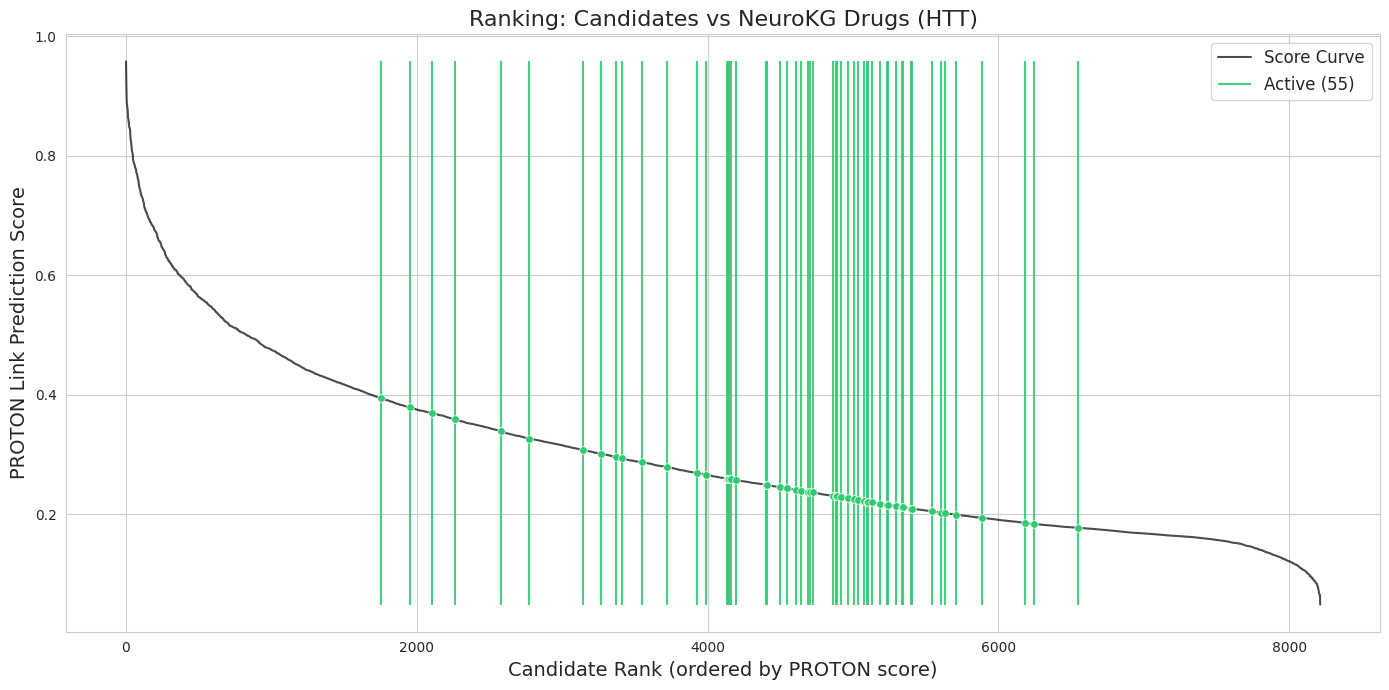

                    INFO     Saved plot to                                                         ]8;id=346820;file:///tmp/ipykernel_2074843/1791655917.py\1791655917.py]8;;\:]8;id=289872;file:///tmp/ipykernel_2074843/1791655917.py#52\52]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/notebooks/mo                 
                             lecular_analysis/hd_ranking_curve_with_background.png                                 

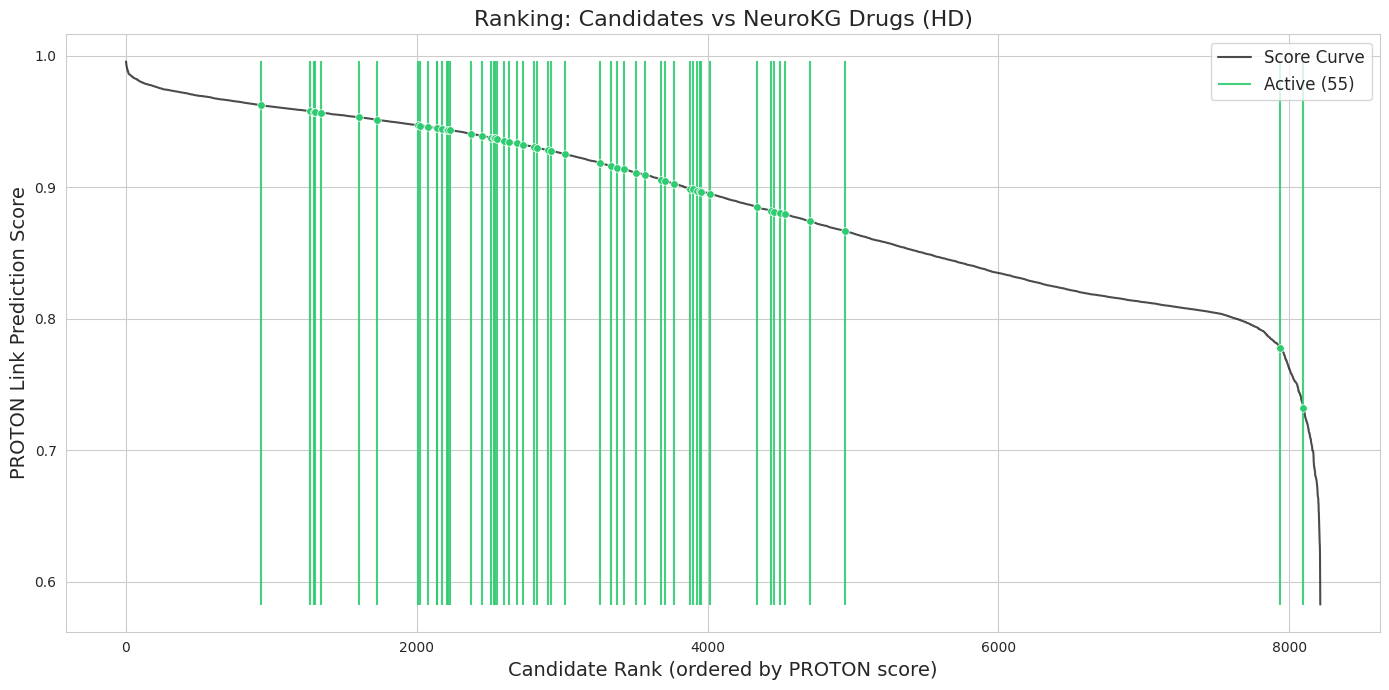

In [39]:
# Plot Rankings with Background
_logger.info("Plotting rankings with NeuroKG background...")

# Plot HTT
plot_monotonically_decreasing(
    combined_ranking_df, 
    'Score_HTT', 
    "Ranking: Candidates vs NeuroKG Drugs (HTT)", 
    "htt_ranking_curve_with_background.png"
)

# Plot HD
plot_monotonically_decreasing(
    combined_ranking_df, 
    'Score_HD', 
    "Ranking: Candidates vs NeuroKG Drugs (HD)", 
    "hd_ranking_curve_with_background.png"
)

In [40]:
# --- Recall @ K Plotting Function ---
def plot_recall_at_k(scores, active_indices, title, filename_suffix, k_values=[10, 20, 30, 40, 50]):
    """
    Plots Recall @ K where K is the top X% of the full sorted list.
    """
    # Sort scores descending
    sorted_indices = np.argsort(-scores) # Returns indices that sort the array
    total_items = len(scores)
    total_actives = len(active_indices)
    
    if total_actives == 0:
        _logger.warning(f"No actives found for Recall@K plot: {title}")
        return

    recalls = []
    labels = []
    
    for k in k_values:
        cutoff = int(total_items * k / 100)
        # Taking top 'cutoff' items
        top_k_indices = sorted_indices[:cutoff]
        
        # Count matches
        # Intersection of top_k_indices and active_indices
        recovered = np.isin(top_k_indices, active_indices).sum()
        recall = recovered / total_actives
        recalls.append(recall)
        labels.append(f"Top {k}%")
        
    # Plot
    plt.figure(figsize=(8, 6))
    # Gradient colors: light to dark blue
    # We use a palette and select colors from it
    base_palette = sns.color_palette("Blues", n_colors=len(k_values) + 2)
    colors = base_palette[2:] # Skip the very lightest ones
    
    bars = plt.bar(labels, recalls, color=colors, edgecolor='black', alpha=0.9)
    
    plt.title(f"Recall @ Top K% - {title}", fontsize=14)
    plt.ylabel("Recall (Fraction of Actives Recovered)", fontsize=12)
    plt.ylim(0, 1.1) 
    
    # Add text labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                 f'{height:.2f}',
                 ha='center', va='bottom', fontsize=11, fontweight='bold')
                 
    output_path = PROJECT_ROOT / f"data/notebooks/molecular_analysis/recall_at_k_{filename_suffix}.png"
    plt.savefig(output_path)
    _logger.info(f"Saved Recall@K plot to {output_path}")
    plt.show()

In [41]:
# --- ChEMBL Background Analysis ---
# Benchmarking Huntington candidates against random ChEMBL molecules (decoys)

_logger.info("Starting ChEMBL Background Analysis...")

# 1. Load ChEMBL Background Data
chembl_csv_path = PROJECT_ROOT / "notebooks/molecular_analysis/filtered_chembl_gba1_merged_filtered_molecules_with_embeddings.csv"
chembl_emb_path = PROJECT_ROOT / "notebooks/molecular_analysis/filtered_chembl_gba1_merged_embeddings.pt"
gba1_ref_path = PROJECT_ROOT / "data/neurokg/drugs/GBA1_hits_with_embeddings.csv"

# Load Embeddings
_logger.info(f"Loading ChEMBL/Merged embeddings from {chembl_emb_path}")
merged_chembl_embeddings = torch.load(chembl_emb_path, map_location='cpu')

# Load Metadata
_logger.info(f"Loading ChEMBL/Merged metadata from {chembl_csv_path}")
chembl_df = pd.read_csv(chembl_csv_path)

# Filter out GBA1 hits from this background set to get "pure" ChEMBL decoys
# (Reusing logic from GBA1 notebook to ensure clean background)
try:
    if gba1_ref_path.exists():
        gba1_ref_df = pd.read_csv(gba1_ref_path)
        # Normalize columns
        chembl_df.columns = [c.lower() for c in chembl_df.columns]
        
        # Determine IDs to exclude
        if 'Sample Data Type' in gba1_ref_df.columns:
            ref_ids = set(gba1_ref_df['Sample Data Type'].astype(str).str.strip().values)
        else:
            ref_ids = set(gba1_ref_df.iloc[:, 0].astype(str).str.strip().values)
            
        # Filter
        merged_ids = chembl_df['id'].astype(str).str.strip()
        is_gba1_hit = merged_ids.isin(ref_ids)
        chembl_indices = np.where(~is_gba1_hit)[0]
        
        _logger.info(f"Filtered out {is_gba1_hit.sum()} GBA1 hits from background.")
        _logger.info(f"Remaining ChEMBL Decoys: {len(chembl_indices)}")
        
        # Subset embeddings and dataframe
        chembl_embeddings = merged_chembl_embeddings[chembl_indices]
        chembl_df = chembl_df.iloc[chembl_indices].reset_index(drop=True)
    else:
        _logger.warning("GBA1 hits usage file not found. Using full merged set as background.")
        chembl_embeddings = merged_chembl_embeddings
except Exception as e:
    _logger.warning(f"Error filtering GBA1 hits: {e}. Using full background.")
    chembl_embeddings = merged_chembl_embeddings

_logger.info(f"Final ChEMBL Background Shape: {chembl_embeddings.shape}")

[02/04/26 17:45:07] INFO     Starting ChEMBL Background Analysis...                                  ]8;id=219227;file:///tmp/ipykernel_2074843/237544523.py\237544523.py]8;;\:]8;id=147901;file:///tmp/ipykernel_2074843/237544523.py#4\4]8;;\

                    INFO     Loading ChEMBL/Merged embeddings from                                  ]8;id=519199;file:///tmp/ipykernel_2074843/237544523.py\237544523.py]8;;\:]8;id=38438;file:///tmp/ipykernel_2074843/237544523.py#12\12]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/notebooks/molecula                
                             r_analysis/filtered_chembl_gba1_merged_embeddings.pt                                  

                    INFO     Loading ChEMBL/Merged metadata from                                    ]8;id=26400;file:///tmp/ipykernel_2074843/237544523.py\237544523.py]8;;\:]8;id=23529;file:///tmp/ipykernel_2074843/237544523.py#16\16]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/notebooks/molecula                
                             r_analysis/filtered_chembl_gba1_merged_filtered_molecules_with_embeddi                
                             ngs.csv                                                                               

                    INFO     Filtered out 72 GBA1 hits from background.                             ]8;id=791604;file:///tmp/ipykernel_2074843/237544523.py\237544523.py]8;;\:]8;id=891038;file:///tmp/ipykernel_2074843/237544523.py#38\38]8;;\

                    INFO     Remaining ChEMBL Decoys: 28495                                         ]8;id=920675;file:///tmp/ipykernel_2074843/237544523.py\237544523.py]8;;\:]8;id=318454;file:///tmp/ipykernel_2074843/237544523.py#39\39]8;;\

                    INFO     Final ChEMBL Background Shape: torch.Size([28495, 512])                ]8;id=163846;file:///tmp/ipykernel_2074843/237544523.py\237544523.py]8;;\:]8;id=618823;file:///tmp/ipykernel_2074843/237544523.py#51\51]8;;\

In [42]:
# 2. Combine Embeddings and Score against Targets
# Structure: [Pretrained (Graph Nodes)] + [Huntington Candidates] + [ChEMBL Decoys]

_logger.info("Combining embeddings for scoring...")

# res_embeddings = Huntington Candidates (from earlier cells)
# chembl_embeddings = ChEMBL Decoys

# Concatenate: Pretrained + Candidates + ChEMBL
full_analysis_embeddings = torch.cat([pretrained_embeddings, res_embeddings, chembl_embeddings], dim=0)

num_pretrained = len(pretrained_embeddings)
num_candidates = len(res_embeddings)
num_chembl = len(chembl_embeddings)

# Indices definitions
candidate_indices_full = torch.arange(num_pretrained, num_pretrained + num_candidates, dtype=torch.long)
chembl_indices_full = torch.arange(num_pretrained + num_candidates, num_pretrained + num_candidates + num_chembl, dtype=torch.long)
# All evaluation molecules together (for ranking curve)
all_eval_indices = torch.cat([candidate_indices_full, chembl_indices_full])

_logger.info(f"Full Embeddings Shape: {full_analysis_embeddings.shape}")
_logger.info(f"Scoring {len(all_eval_indices)} molecules ({num_candidates} Candidates + {num_chembl} Decoys)...")

def score_against_target_chembl_bg(target_idx, target_name, etype):
    # Batch Score: All Eval Molecules -> Target
    batch_src = all_eval_indices
    batch_dst = torch.full((len(all_eval_indices),), target_idx, dtype=torch.long)
    
    with torch.no_grad():
        scores = pretrain_model.get_scores_from_embeddings(
            batch_src, 
            batch_dst, 
            etype, 
            embeddings=full_analysis_embeddings, 
            use_cache=False, 
            query_kg=kg
        )
    return scores.cpu().numpy()

# A. Score vs HTT protein
_logger.info("Scoring against HTT Protein...")
scores_htt_all = score_against_target_chembl_bg(htt_idx, "HTT", ("drug", "drug_protein", "gene/protein"))

# B. Score vs Huntington Disease
_logger.info("Scoring against Huntington Disease...")
scores_hd_all = score_against_target_chembl_bg(hd_idx, "Huntington Disease", ("drug", "rev_indication", "disease"))

_logger.info("Scoring complete.")

                    INFO     Combining embeddings for scoring...                                    ]8;id=787666;file:///tmp/ipykernel_2074843/1441544052.py\1441544052.py]8;;\:]8;id=990070;file:///tmp/ipykernel_2074843/1441544052.py#4\4]8;;\

                    INFO     Full Embeddings Shape: torch.Size([175570, 512])                      ]8;id=471385;file:///tmp/ipykernel_2074843/1441544052.py\1441544052.py]8;;\:]8;id=452134;file:///tmp/ipykernel_2074843/1441544052.py#22\22]8;;\

                    INFO     Scoring 28550 molecules (55 Candidates + 28495 Decoys)...             ]8;id=798616;file:///tmp/ipykernel_2074843/1441544052.py\1441544052.py]8;;\:]8;id=58379;file:///tmp/ipykernel_2074843/1441544052.py#23\23]8;;\

                    INFO     Scoring against HTT Protein...                                        ]8;id=225465;file:///tmp/ipykernel_2074843/1441544052.py\1441544052.py]8;;\:]8;id=935072;file:///tmp/ipykernel_2074843/1441544052.py#42\42]8;;\

                    INFO     Scoring against Huntington Disease...                                 ]8;id=603917;file:///tmp/ipykernel_2074843/1441544052.py\1441544052.py]8;;\:]8;id=326729;file:///tmp/ipykernel_2074843/1441544052.py#46\46]8;;\

                    INFO     Scoring complete.                                                     ]8;id=727501;file:///tmp/ipykernel_2074843/1441544052.py\1441544052.py]8;;\:]8;id=872769;file:///tmp/ipykernel_2074843/1441544052.py#49\49]8;;\

                    INFO     Saved plot to                                                          ]8;id=628999;file:///tmp/ipykernel_2074843/952074595.py\952074595.py]8;;\:]8;id=897229;file:///tmp/ipykernel_2074843/952074595.py#68\68]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/notebooks/mol                
                             ecular_analysis/htt_ranking_vs_chembl.png                                             

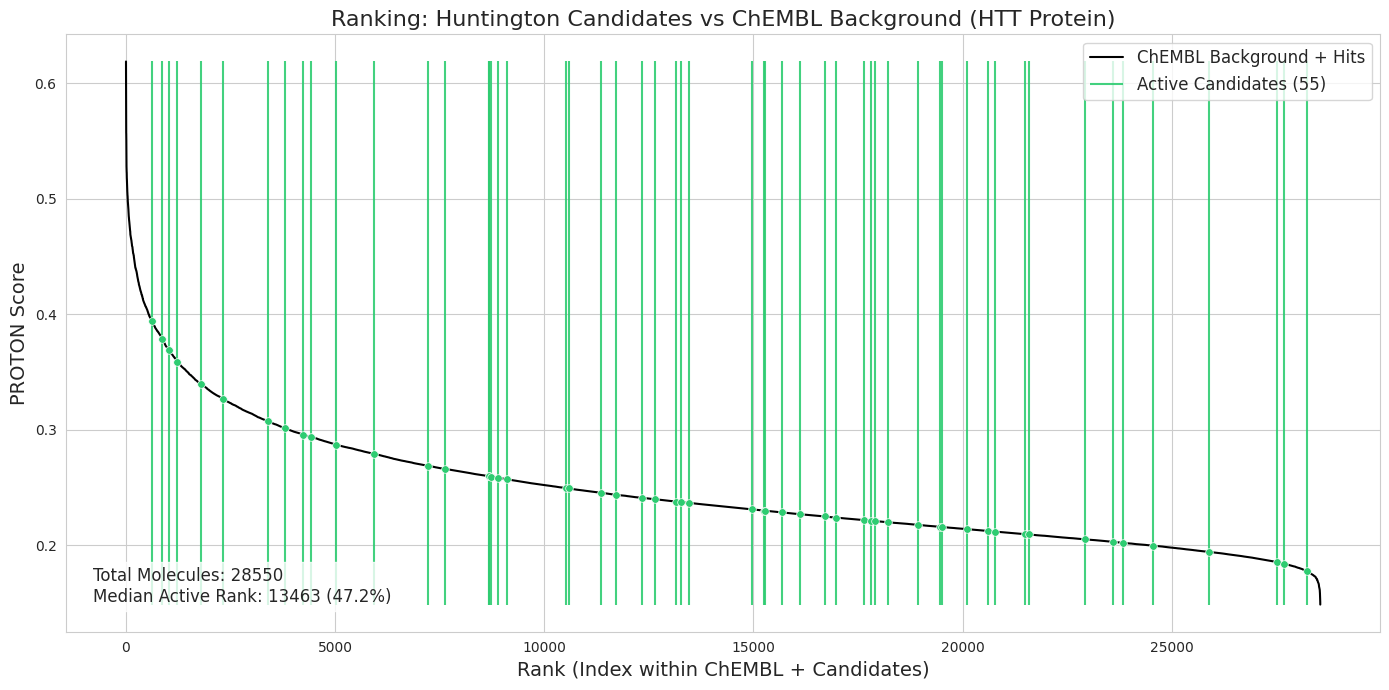

[02/04/26 17:45:08] INFO     Saved plot to                                                          ]8;id=568840;file:///tmp/ipykernel_2074843/952074595.py\952074595.py]8;;\:]8;id=653415;file:///tmp/ipykernel_2074843/952074595.py#68\68]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/notebooks/mol                
                             ecular_analysis/hd_ranking_vs_chembl.png                                              

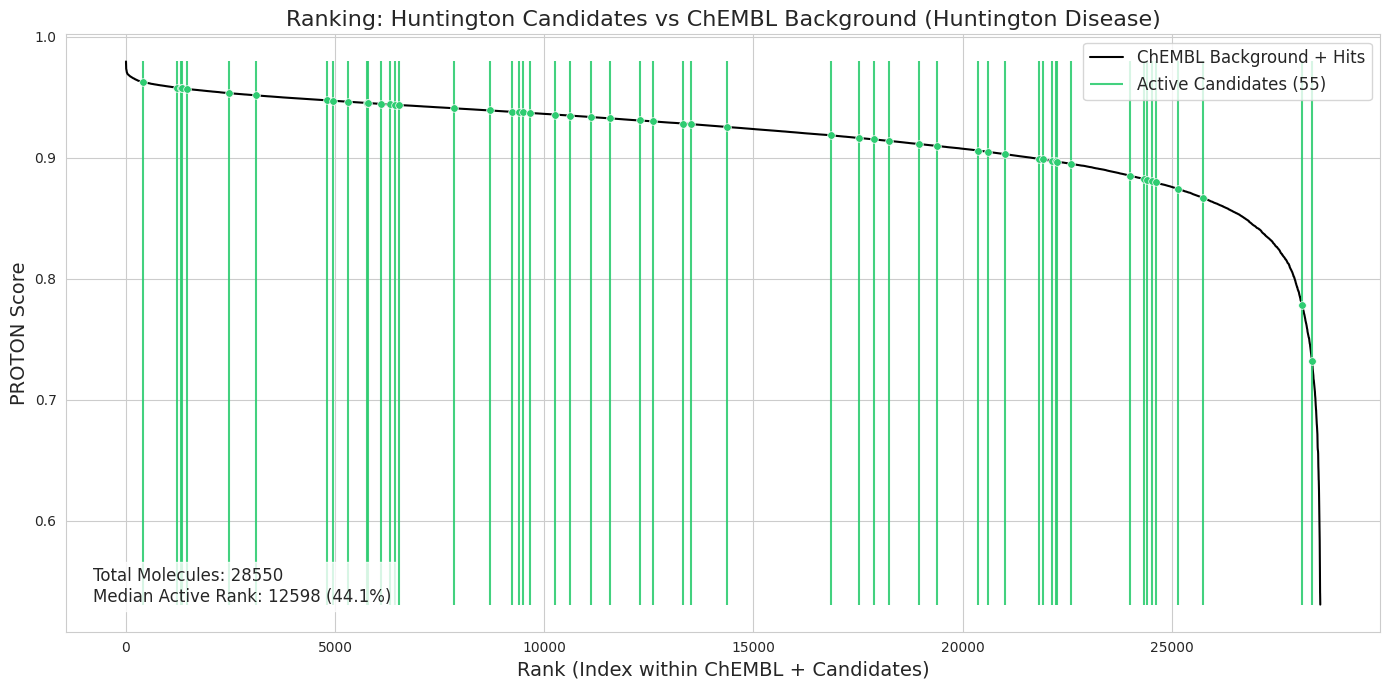

In [43]:
# 3. Visualization: Hits vs ChEMBL Background
# We plot the ranking curve of ALL molecules (ChEMBL + Hits)
# And highlight the active/inactive hits

def plot_chembl_benchmarking(all_scores, title, filename):
    # Sort scores descending
    sorted_indices = np.argsort(-all_scores)
    sorted_scores = all_scores[sorted_indices]
    
    # Identify positions of Active and Inactive Candidates in the sorted list
    # candidate_indices_full corresponds to the FIRST 'num_candidates' elements of 'all_scores'
    # (since we concatenated candidates first, then chembl)
    
    # Map from original index (0..total-1) to sorted rank
    # We need to know which of the original indices correspond to Actives/Inactives
    
    # Get local indices (0 to num_candidates-1) of actives/inactives from original dataframe
    active_local_idx = candidates_df.index[candidates_df['pubchem_activity_outcome'].str.lower().str.strip() == 'active'].values
    inactive_local_idx = candidates_df.index[candidates_df['pubchem_activity_outcome'].str.lower().str.strip() == 'inactive'].values
    
    # Convert to indices in 'all_scores' array
    # Candidates are at the start of all_scores (indices 0 to num_candidates)
    active_indices_global = active_local_idx
    inactive_indices_global = inactive_local_idx
    
    # Find these global indices in the SORTED list
    is_active_sorted = np.isin(sorted_indices, active_indices_global)
    is_inactive_sorted = np.isin(sorted_indices, inactive_indices_global)
    
    active_ranks = np.where(is_active_sorted)[0]
    inactive_ranks = np.where(is_inactive_sorted)[0]
    
    active_scores_sorted = sorted_scores[is_active_sorted]
    inactive_scores_sorted = sorted_scores[is_inactive_sorted]
    
    # Plot
    plt.figure(figsize=(14, 7))
    
    # Background Curve (Black)
    plt.plot(np.arange(len(sorted_scores)), sorted_scores, color='black', linewidth=1.5, label='ChEMBL Background + Hits')
    
    # Highlight Inactives (Red)
    if len(inactive_ranks) > 0:
        plt.vlines(inactive_ranks, ymin=min(sorted_scores), ymax=max(sorted_scores), 
                   color='#E74C3C', alpha=0.4, linewidth=0.8, label=f'Inactive Candidates ({len(inactive_ranks)})')

    # Highlight Actives (Green)
    if len(active_ranks) > 0:
        plt.vlines(active_ranks, ymin=min(sorted_scores), ymax=max(sorted_scores), 
                   color='#2ECC71', alpha=0.9, linewidth=1.5, label=f'Active Candidates ({len(active_ranks)})')
        plt.scatter(active_ranks, active_scores_sorted, color='#2ECC71', s=30, zorder=5, edgecolors='white', linewidth=0.5)

    plt.title(title, fontsize=16)
    plt.xlabel("Rank (Index within ChEMBL + Candidates)", fontsize=14)
    plt.ylabel("PROTON Score", fontsize=14)
    plt.legend(loc="upper right", fontsize=12)
    
    # Add stats annotation
    median_active = np.median(active_ranks) if len(active_ranks) > 0 else 0
    total_mols = len(sorted_scores)
    stats_text = f"Total Molecules: {total_mols}\nMedian Active Rank: {median_active:.0f} ({median_active/total_mols*100:.1f}%)"
    plt.text(0.02, 0.05, stats_text, transform=plt.gca().transAxes, fontsize=12, 
             bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    output_path = PROJECT_ROOT / f"data/notebooks/molecular_analysis/{filename}"
    plt.savefig(output_path)
    _logger.info(f"Saved plot to {output_path}")
    plt.show()

# Plot vs HTT
plot_chembl_benchmarking(
    scores_htt_all, 
    "Ranking: Huntington Candidates vs ChEMBL Background (HTT Protein)", 
    "htt_ranking_vs_chembl.png"
)

# Plot vs HD
plot_chembl_benchmarking(
    scores_hd_all, 
    "Ranking: Huntington Candidates vs ChEMBL Background (Huntington Disease)", 
    "hd_ranking_vs_chembl.png"
)

                    INFO     Computing Recall @ K for NeuroKG background...                         ]8;id=799168;file:///tmp/ipykernel_2074843/4092216364.py\4092216364.py]8;;\:]8;id=20698;file:///tmp/ipykernel_2074843/4092216364.py#3\3]8;;\

                    INFO     Saved Recall@K plot to                                                ]8;id=504460;file:///tmp/ipykernel_2074843/1373267798.py\1373267798.py]8;;\:]8;id=210905;file:///tmp/ipykernel_2074843/1373267798.py#52\52]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/notebooks/mo                 
                             lecular_analysis/recall_at_k_neurokg_htt.png                                          

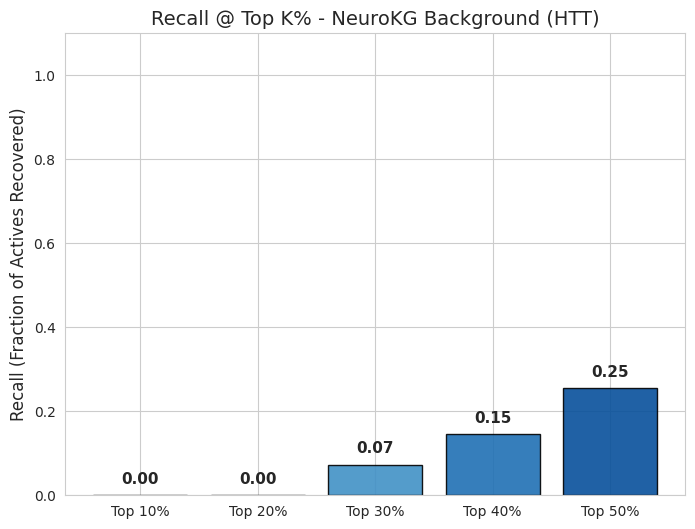

                    INFO     Saved Recall@K plot to                                                ]8;id=627635;file:///tmp/ipykernel_2074843/1373267798.py\1373267798.py]8;;\:]8;id=178842;file:///tmp/ipykernel_2074843/1373267798.py#52\52]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/notebooks/mo                 
                             lecular_analysis/recall_at_k_neurokg_hd.png                                           

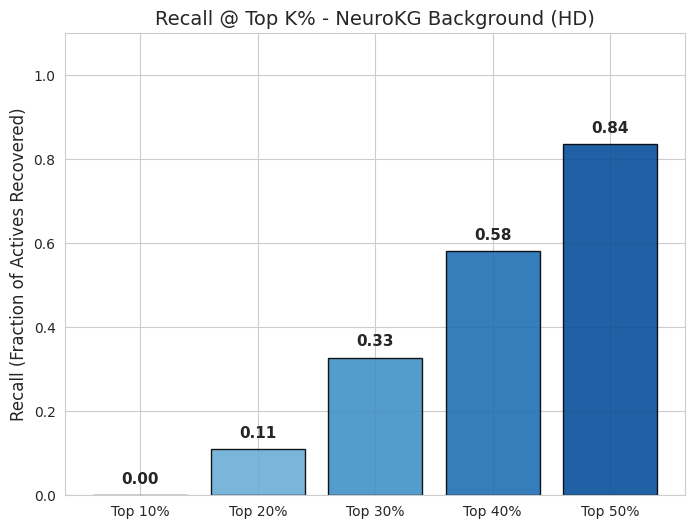

In [44]:
# Use combined_ranking_df for Recall analysis
# Identify active indices in the combined DataFrame
_logger.info("Computing Recall @ K for NeuroKG background...")
active_bg_mask = combined_ranking_df['pubchem_activity_outcome'].astype(str).str.strip().str.lower() == 'active'
active_bg_indices = np.where(active_bg_mask)[0]

# Scores arrays from DF
scores_htt_bg = combined_ranking_df['Score_HTT'].values
scores_hd_bg = combined_ranking_df['Score_HD'].values

# Plot HTT
plot_recall_at_k(
    scores=scores_htt_bg,
    active_indices=active_bg_indices,
    title="NeuroKG Background (HTT)",
    filename_suffix="neurokg_htt"
)

# Plot HD
plot_recall_at_k(
    scores=scores_hd_bg,
    active_indices=active_bg_indices,
    title="NeuroKG Background (HD)",
    filename_suffix="neurokg_hd"
)

[02/04/26 17:45:09] INFO     Computing Recall @ K for ChEMBL background...                          ]8;id=422352;file:///tmp/ipykernel_2074843/1487210272.py\1487210272.py]8;;\:]8;id=36595;file:///tmp/ipykernel_2074843/1487210272.py#4\4]8;;\

                    INFO     Saved Recall@K plot to                                                ]8;id=819007;file:///tmp/ipykernel_2074843/1373267798.py\1373267798.py]8;;\:]8;id=667737;file:///tmp/ipykernel_2074843/1373267798.py#52\52]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/notebooks/mo                 
                             lecular_analysis/recall_at_k_chembl_htt.png                                           

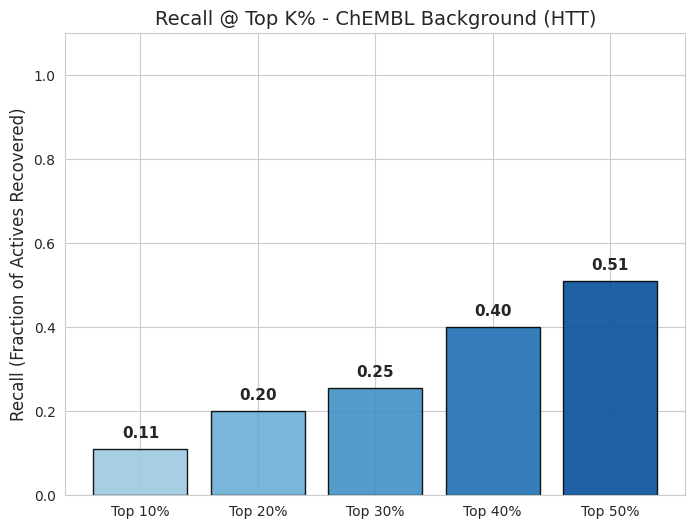

                    INFO     Saved Recall@K plot to                                                ]8;id=964158;file:///tmp/ipykernel_2074843/1373267798.py\1373267798.py]8;;\:]8;id=741265;file:///tmp/ipykernel_2074843/1373267798.py#52\52]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/notebooks/mo                 
                             lecular_analysis/recall_at_k_chembl_hd.png                                            

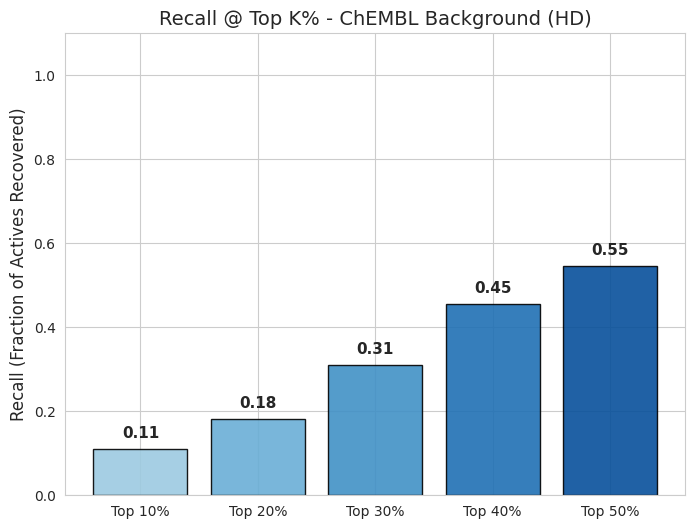

In [45]:
# Use ChEMBL scores for Recall analysis
# Identify active indices in the full evaluation list (Candidates + ChEMBL)
# Actives are inside 'candidates' part, which is the first block
_logger.info("Computing Recall @ K for ChEMBL background...")

# We need positions of actives in the [Candidates + ChEMBL] array
# 'candidates_df' (which corresponds to first part of array) has active status
if 'pubchem_activity_outcome' in candidates_df.columns:
    active_local = candidates_df['pubchem_activity_outcome'].astype(str).str.strip().str.lower() == 'active'
    active_local_indices = np.where(active_local)[0]
    # Since candidates are at the start of the combined array, these are the global indices too
    active_chembl_indices = active_local_indices
else:
    active_chembl_indices = []

# Plot HTT
plot_recall_at_k(
    scores=scores_htt_all,
    active_indices=active_chembl_indices,
    title="ChEMBL Background (HTT)",
    filename_suffix="chembl_htt"
)

# Plot HD
plot_recall_at_k(
    scores=scores_hd_all,
    active_indices=active_chembl_indices,
    title="ChEMBL Background (HD)",
    filename_suffix="chembl_hd"
)